# Homework of Principal Component Analysis

* Marco Bottino s274110
* Maria Lovera s278425

Table of contents:
1. [Extraction of the working dataset](#section_1)
2. [Principal Component Analysis](#section_2)
  * Principal components extraction
  * PCA plots
3. [Evaluation set analysis and k-NN](#section_3)
  * PCA plots for evaluation set
  * k-NN

Libraries and functions

In [ ]:
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import statistics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# mean_relative_error
def mean_relative_error(y_true, y_pred):
    relative_error = np.average(np.abs(y_true - y_pred) / y_true, axis=0)
    return relative_error

# Extraction of the working dataset

In [ ]:
# import the dataset as a pandas dataframe
data = []
with open("COMBO17.csv") as COMBO17:
    for cols in csv.reader(COMBO17):
        data.append(cols)
header = data[0]
combo_df = pd.DataFrame(data[1:], columns = header)
for i in header:
  combo_df[i] = pd.to_numeric(combo_df[i], downcast="float")


# setting the seed
s = 278425
np.random.seed(s)

# feature creation
combo_df['galaxy_size'] = combo_df['Rmag'] - combo_df['mumax']

# checking for Nans
combo_df.isnull().values.any()
print('Number of NaNs: ' + str(combo_df.isnull().sum().sum())+ '\n')
combo_df_nan_dropped = combo_df.dropna()
print('Size of the dataset after NaN drop: ' + str(combo_df_nan_dropped.shape) + '-> 24 rows dropped\n\n' )

# extract a sub-dataframe containing 2500 random rows
list_av_indexes = list(combo_df_nan_dropped.index)
n_rows = len(combo_df_nan_dropped)
rows_to_remove = n_rows - 2500
indexes_to_remove = np.random.choice(list_av_indexes, rows_to_remove, replace=False)
combo_pca = combo_df_nan_dropped.drop(index = list(indexes_to_remove), axis = 0)
indexes_pca = combo_pca.index.tolist()
combo_eval = combo_df_nan_dropped.drop(indexes_pca, axis = 0)

# create working datasets
combo_pca.to_csv('COMBO17pca_278425.csv')
combo_eval.to_csv('COMBO17eval_278425.csv')

# pull-off the features related to the redshift
combo_pca_clean = combo_pca.drop(['Nr','Mcz', 'e.Mcz', 'MCzml', 'chi2red'], axis = 1)
header_pca = list(combo_pca_clean.columns)

# scaling data
z_norm = StandardScaler()
combo_hat = z_norm.fit_transform(combo_pca_clean)

# printing the first rows of our dataset before normalization
print('First rows of data before normalization:')
combo_pca_clean.head(5)


Number of NaNs: 50

Size of the dataset after NaN drop: (3438, 66)-> 24 rows dropped


First rows of data before normalization:


,Rmag,e.Rmag,ApDRmag,mumax,UjMAG,e.UjMAG,BjMAG,e.BjMAG,VjMAG,e.VjMAG,usMAG,e.usMAG,gsMAG,e.gsMAG,rsMAG,e.rsMAG,UbMAG,e.UbMAG,BbMAG,e.BbMAG,VbMAG,e.VbMAG,S280MAG,e.S280MAG,W420FE,e.W420FE,W462FE,e.W462FE,W485FD,e.W485FD,W518FE,e.W518FE,W571FS,e.W571FS,W604FE,e.W604FE,W646FD,e.W646FD,W696FE,e.W696FE,W753FE,e.W753FE,W815FS,e.W815FS,W856FD,e.W856FD,W914FD,e.W914FD,W914FE,e.W914FE,UFS,e.UFS,BFS,e.BFS,VFD,e.VFD,RFS,e.RFS,IFD,e.IFD,galaxy_size
1,25.013000,0.181,-0.135,25.302999,-18.280001,0.22,17.860001,0.55,-18.200001,0.55,-18.420000,0.22,-17.959999,0.55,-18.430000,0.55,-18.360001,0.22,-17.850000,0.55,-18.190001,0.55,-17.969999,0.540000,0.000324,0.00319,0.00514,0.00323,0.00273,0.00485,0.000785,0.00485,0.00991,0.00284,0.00905,0.00445,0.002980,0.00892,0.00983,0.00343,0.01420,0.00527,0.01470,0.00308,0.01140,0.00627,0.0103,0.00646,0.02630,0.01480,0.00706,0.00238,0.00420,0.00115,0.003930,0.00182,0.00723,0.000500,0.00973,0.00460,-0.289999
2,24.246000,0.054,0.821,23.511000,-19.750000,0.14,-19.910000,0.14,-20.410000,0.14,-19.870001,0.14,-20.049999,0.14,-20.709999,0.14,-19.820000,0.14,-19.889999,0.14,-20.400000,0.14,-19.770000,0.120000,0.013000,0.00411,0.01970,0.00432,0.02550,0.00428,0.015900,0.00464,0.02290,0.00455,0.02340,0.00374,0.023100,0.00667,0.02720,0.00405,0.03540,0.00456,0.04530,0.00360,0.07810,0.00658,0.0711,0.00613,0.06410,0.01270,0.01260,0.00184,0.01830,0.00115,0.018800,0.00167,0.02880,0.000655,0.05700,0.00465,0.735001
3,25.202999,0.128,0.639,24.948000,-17.830000,0.17,-17.389999,0.31,-17.670000,0.31,-17.980000,0.17,-17.469999,0.31,-17.889999,0.31,-17.920000,0.17,-17.379999,0.31,-17.670000,0.31,-18.120001,0.280000,0.011900,0.00270,0.01590,0.00314,0.00156,0.00493,0.002610,0.00476,0.00176,0.00310,0.00916,0.00332,0.006330,0.00596,0.01230,0.00248,0.00225,0.00692,0.01690,0.00276,0.00875,0.00672,0.0070,0.00557,0.00587,0.01140,0.01410,0.00186,0.01180,0.00110,0.009670,0.00204,0.01050,0.000416,0.01340,0.00330,0.254999
4,25.504000,0.112,-1.588,24.934000,-17.690001,0.42,-18.400000,0.83,-19.370001,0.83,-17.809999,0.42,-18.690001,0.83,-19.879999,0.83,-17.760000,0.42,-18.350000,0.83,-19.370001,0.83,-13.930000,45.110001,0.001350,0.00371,0.00509,0.00268,0.00185,0.00401,0.009960,0.00432,0.00344,0.00448,0.00632,0.00366,-0.000184,0.01240,0.00554,0.00293,0.01620,0.00497,0.00676,0.00314,0.01020,0.00610,0.0133,0.00682,0.01990,0.01030,0.00514,0.00170,0.00102,0.00127,0.000038,0.00160,0.00139,0.000499,0.00590,0.00444,0.570000
6,25.705999,0.257,0.199,25.271000,-17.090000,0.30,-16.059999,1.94,-16.230000,1.94,-17.260000,0.30,-16.110001,1.94,-16.389999,1.94,-17.190001,0.30,-16.049999,1.94,-16.219999,1.94,-17.809999,0.390000,0.008980,0.00288,0.00406,0.00265,0.00486,0.00363,0.001780,0.00357,0.00537,0.00301,0.00262,0.00368,0.013200,0.00644,0.00776,0.00308,0.01190,0.00443,0.00561,0.00275,0.00684,0.00557,0.0144,0.00615,0.01850,0.00876,0.01230,0.00210,0.00622,0.00124,0.005040,0.00129,0.00398,0.000429,0.00271,0.00480,0.434999


Before standardization:
      Feature Var explained Cum Var explained
0       BjMAG       7.79034           7.79034
1       rsMAG        7.4371           15.2274
2       VbMAG       7.35502           22.5825
3       VjMAG       7.35275           29.9352
4       gsMAG       7.06986           37.0051
5       BbMAG       6.93184           43.9369
6       UjMAG       6.48058           50.4175
7       UbMAG       6.46896           56.8864
8       usMAG       6.44836           63.3348
9     S280MAG       6.34909           69.6839
10       Rmag       3.43915            73.123
11    e.gsMAG       3.24876           76.3718
12    e.VjMAG       3.24702           79.6188
13    e.VbMAG       3.24702           82.8658
14    e.rsMAG       3.24573           86.1116
15    e.BbMAG       3.22058           89.3321
16    e.BjMAG       3.22058           92.5527
17  e.S280MAG       2.62994           95.1826
18      mumax       1.72291           96.9056
19     W420FE       1.31089           98.2165

After sta

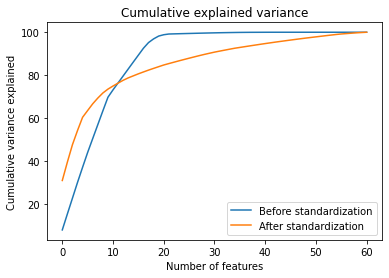



Heatmap:


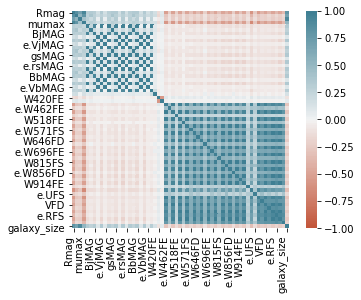

In [ ]:
### feature analysis

## before standardization
n_columns_b = combo_pca_clean.shape[1]
v_features_b = []

for i in combo_pca_clean.columns:
  v_features_b.append(statistics.variance(combo_pca_clean[i]))


v_features_b = [x / sum(v_features_b) * 100 for x in v_features_b]
ind_b = np.argsort(v_features_b)
v_features_b.sort(reverse = True)


columns_sorted_b=[combo_pca_clean.columns[i] for i in ind_b]
columns_sorted_b.reverse()

cum_v_b = np.cumsum(v_features_b)

var_order_b = pd.DataFrame([columns_sorted_b, v_features_b, cum_v_b]).transpose()
var_order_b.columns = ['Feature', 'Var explained','Cum Var explained']
var_order_b.style.set_caption("Dataset before z-normalization")
print('Before standardization:')
print(var_order_b.head(20))

print()

## after standardization
n_columns = combo_hat.shape[1]
v_features = []

for i,col in enumerate(combo_pca_clean.columns):
  v_features.append(np.var(combo_hat[i]))


v_features = [x / sum(v_features) * 100 for x in v_features]
ind = np.argsort(v_features)
v_features.sort(reverse = True)


columns_sorted=[combo_pca_clean.columns[i] for i in ind]
columns_sorted.reverse()

cum_v = np.cumsum(v_features)

var_order = pd.DataFrame([columns_sorted, v_features, cum_v]).transpose()
var_order.columns = ['Feature', 'Var explained','Cum Var explained']
var_order.style.set_caption("Dataset after z-normalization")
print('After standardization:')
print(var_order.head(20))

cum_before = plt.plot(cum_v_b)
cum_after = plt.plot(cum_v)
plt.title('Cumulative explained variance')
plt.xlabel('Number of features')
plt.ylabel('Cumulative variance explained')
plt.legend(['Before standardization', 'After standardization'])

plt.show()

print()
print()

# heatmap 
print('Heatmap:')
corr = combo_pca_clean.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
);


# Principal Component Analysis

##  Principal components extraction

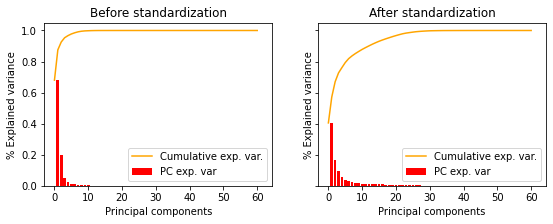

In [ ]:
# PCA before and after scalarization
n = 61
pca_before = PCA(n_components = n, svd_solver = 'full')
pca = PCA(n_components = n, svd_solver = 'full')
pca_before.fit(combo_pca_clean)
pca.fit(combo_hat)

pca_bef_af = pd.DataFrame([pca_before.explained_variance_ratio_, pca.explained_variance_ratio_]).transpose()
pca_bef_af.columns = ['Before', 'After']
pca_bef_af.head(10)

# cumulative variance before and after scalarization
cumvar = np.zeros([n,1])
cumvar_before = np.zeros([n,1])
for i in range(n):
  cumvar_before[i] = sum(pca_before.explained_variance_ratio_[:i+1])
  cumvar[i] = sum(pca.explained_variance_ratio_[:i+1])

# plots before and after scalarization
fig, axs = plt.subplots(1, 2, figsize = (9,3), sharey=True)
axs[0].bar(range(1,len(pca_before.explained_variance_ratio_)+1),pca_before.explained_variance_ratio_, color = 'red')
axs[0].plot(cumvar_before,color = 'orange')
axs[1].bar(range(1,len(pca.explained_variance_ )+1),pca.explained_variance_ratio_ , color = 'red')
axs[1].plot(cumvar,color = 'orange')
axs[0].set_ylabel('% Explained variance')
axs[0].set_xlabel('Principal components')
axs[1].set_xlabel('Principal components')
axs[1].set_ylabel('% Explained variance')
axs[0].set_title('Before standardization')
axs[1].set_title('After standardization')
axs[0].legend(['Cumulative exp. var.','PC exp. var'])
axs[1].legend(['Cumulative exp. var.','PC exp. var'])

In [ ]:
# consider the data after standardization
# we can observe that with 13 PCs we are already able to explain more than 90% of the variance
tit = []
for i,col in enumerate(combo_pca_clean.columns):
  tit.append(str(i+1) + ' comp. expl.')

cumvar_pc = pd.DataFrame(cumvar).transpose()
cumvar_pc.columns = tit
cumvar_pc


,1 comp. expl.,2 comp. expl.,3 comp. expl.,4 comp. expl.,5 comp. expl.,6 comp. expl.,7 comp. expl.,8 comp. expl.,9 comp. expl.,10 comp. expl.,11 comp. expl.,12 comp. expl.,13 comp. expl.,14 comp. expl.,15 comp. expl.,16 comp. expl.,17 comp. expl.,18 comp. expl.,19 comp. expl.,20 comp. expl.,21 comp. expl.,22 comp. expl.,23 comp. expl.,24 comp. expl.,25 comp. expl.,26 comp. expl.,27 comp. expl.,28 comp. expl.,29 comp. expl.,30 comp. expl.,31 comp. expl.,32 comp. expl.,33 comp. expl.,34 comp. expl.,35 comp. expl.,36 comp. expl.,37 comp. expl.,38 comp. expl.,39 comp. expl.,40 comp. expl.,41 comp. expl.,42 comp. expl.,43 comp. expl.,44 comp. expl.,45 comp. expl.,46 comp. expl.,47 comp. expl.,48 comp. expl.,49 comp. expl.,50 comp. expl.,51 comp. expl.,52 comp. expl.,53 comp. expl.,54 comp. expl.,55 comp. expl.,56 comp. expl.,57 comp. expl.,58 comp. expl.,59 comp. expl.,60 comp. expl.,61 comp. expl.
0,0.40496,0.571517,0.669818,0.726774,0.76093,0.793663,0.818701,0.836545,0.851718,0.86526,0.878319,0.88986,0.900862,0.911589,0.921397,0.930653,0.938827,0.946467,0.95357,0.960639,0.967188,0.973364,0.979011,0.98324,0.986457,0.989531,0.99224,0.994108,0.995679,0.996916,0.997987,0.9985,0.998848,0.999181,0.999477,0.999559,0.999635,0.999696,0.999755,0.999803,0.999838,0.99987,0.999895,0.999918,0.999937,0.999954,0.999968,0.999977,0.999984,0.999988,0.999991,0.999994,0.999997,0.999999,1.0,1.0,1.0,1.0,1.0,1.0,1.0


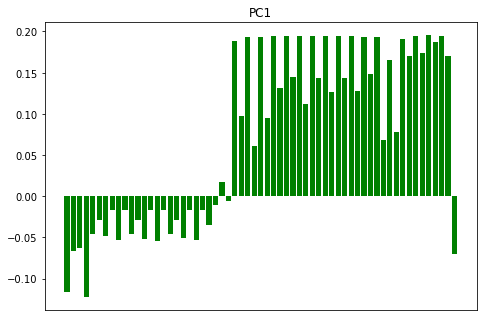



 Top features for PC1: 
  Feature Component
0     RFS   0.19526
1     VFD  0.194994
2  W753FE  0.194943
3  W604FE  0.194927
4  W646FD  0.194787
5  W815FS  0.194624
6  W696FE  0.194539
7  W571FS  0.194501
8     IFD  0.194126
9  W856FD  0.194039

Bottom features for PC1: 
        Feature  Component
51        BbMAG  -0.050579
52        gsMAG -0.0517626
53        VjMAG -0.0534122
54        VbMAG -0.0534274
55        rsMAG -0.0544538
56      ApDRmag -0.0634369
57       e.Rmag -0.0667143
58  galaxy_size -0.0695302
59         Rmag  -0.116371
60        mumax  -0.122592


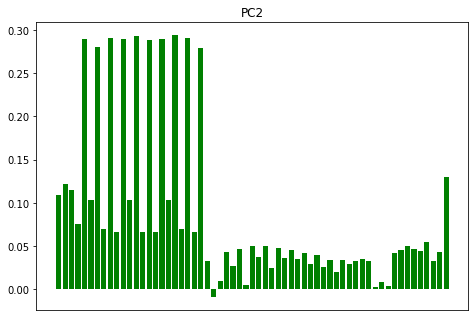



 Top features for PC2: 
   Feature Component
0    BbMAG  0.293424
1    gsMAG  0.292461
2    VjMAG  0.289897
3    VbMAG  0.289872
4    UjMAG  0.289531
5    UbMAG  0.289479
6    usMAG   0.28944
7    rsMAG  0.288382
8    BjMAG   0.27999
9  S280MAG  0.278868

Bottom features for PC2: 
     Feature   Component
51  e.W462FE    0.027149
52  e.W753FE   0.0256388
53  e.W571FS   0.0244721
54  e.W815FS   0.0203215
55  e.W420FE  0.00924275
56       UFS  0.00885969
57  e.W485FD  0.00532819
58     e.UFS  0.00418835
59  e.W914FE  0.00256042
60    W420FE -0.00900767


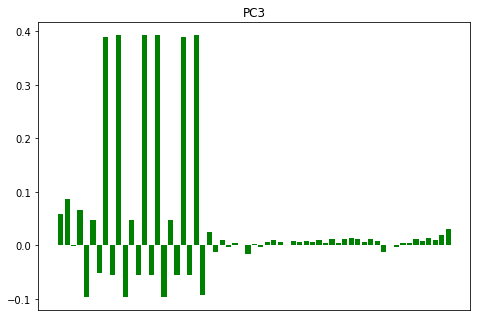



 Top features for PC3: 
   Feature  Component
0  e.gsMAG   0.392051
1  e.VjMAG   0.391988
2  e.VbMAG   0.391988
3  e.rsMAG   0.391865
4  e.BjMAG   0.389814
5  e.BbMAG   0.389813
6   e.Rmag  0.0860953
7    mumax  0.0657535
8     Rmag  0.0590012
9  e.UbMAG  0.0468107

Bottom features for PC3: 
    Feature  Component
51    BjMAG -0.0527636
52    gsMAG -0.0548867
53    BbMAG -0.0554703
54    rsMAG -0.0556566
55    VbMAG -0.0561147
56    VjMAG -0.0561175
57  S280MAG -0.0941081
58    usMAG -0.0968732
59    UbMAG -0.0971981
60    UjMAG -0.0973158


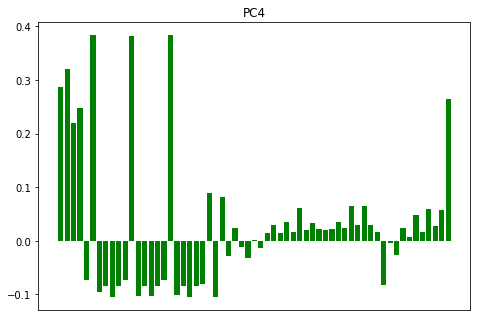



 Top features for PC4: 
       Feature  Component
0      e.UjMAG   0.383025
1      e.UbMAG   0.383025
2      e.usMAG   0.382632
3       e.Rmag   0.319672
4         Rmag   0.287376
5  galaxy_size   0.264263
6        mumax   0.247066
7      ApDRmag   0.220032
8    e.S280MAG  0.0899764
9     e.W420FE  0.0810237

Bottom features for PC4: 
    Feature  Component
51  e.BbMAG -0.0843996
52  e.BjMAG -0.0843997
53  e.rsMAG -0.0844636
54    BjMAG -0.0960889
55    BbMAG  -0.100669
56    gsMAG  -0.102932
57    rsMAG  -0.103734
58    VjMAG  -0.104757
59    VbMAG  -0.104758
60   W420FE  -0.105148


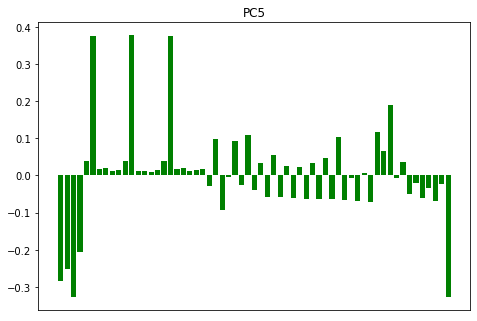



 Top features for PC5: 
    Feature  Component
0   e.usMAG   0.376885
1   e.UjMAG   0.376469
2   e.UbMAG   0.376469
3     e.UFS   0.189556
4  e.W914FE   0.116528
5  e.W485FD   0.107741
6  e.W815FS   0.102398
7    W420FE  0.0976125
8  e.W462FE  0.0933531
9       UFS  0.0649676

Bottom features for PC5: 
        Feature  Component
51       W856FD -0.0672026
52          IFD -0.0682732
53       W914FD -0.0699657
54       W914FE -0.0703797
55     e.W420FE -0.0943184
56        mumax  -0.205789
57       e.Rmag  -0.251786
58         Rmag  -0.285231
59      ApDRmag  -0.327135
60  galaxy_size  -0.327849


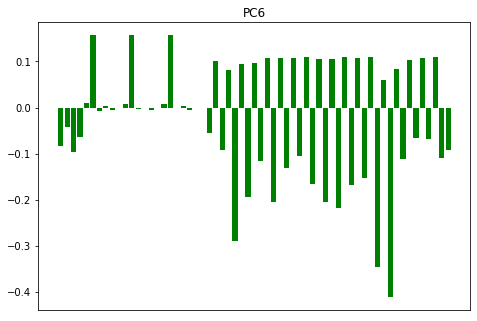



 Top features for PC6: 
   Feature Component
0  e.UjMAG  0.156687
1  e.UbMAG  0.156687
2  e.usMAG  0.156684
3   W696FE  0.110108
4   W856FD  0.110018
5   W914FE  0.109764
6      IFD   0.10871
7   W646FD  0.108611
8   W914FD  0.108548
9   W604FE  0.107257

Bottom features for PC6: 
     Feature Component
51  e.W914FD -0.154022
52  e.W696FE -0.165787
53  e.W856FD -0.168486
54  e.W485FD -0.194765
55  e.W753FE -0.205044
56  e.W571FS -0.205768
57  e.W815FS -0.217624
58  e.W462FE -0.290759
59  e.W914FE -0.347475
60     e.UFS -0.412191


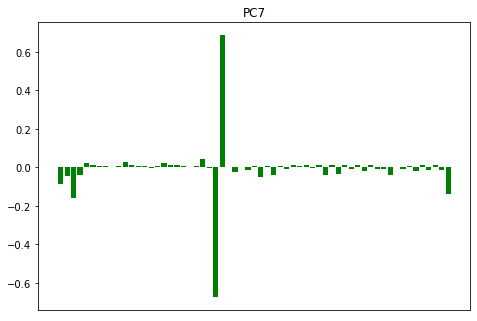



 Top features for PC7: 
    Feature  Component
0  e.W420FE   0.685932
1   S280MAG   0.041168
2     usMAG  0.0249242
3     UbMAG  0.0247426
4     UjMAG  0.0242955
5    W914FE  0.0132948
6    W815FS  0.0132783
7       IFD  0.0129356
8    W856FD  0.0122654
9   e.usMAG   0.011928

Bottom features for PC7: 
        Feature  Component
51     e.W571FS -0.0386188
52     e.W753FE  -0.039108
53        e.UFS -0.0397636
54        mumax -0.0410094
55       e.Rmag  -0.045797
56     e.W518FE -0.0526791
57         Rmag -0.0885026
58  galaxy_size  -0.139705
59      ApDRmag  -0.158372
60       W420FE  -0.675641


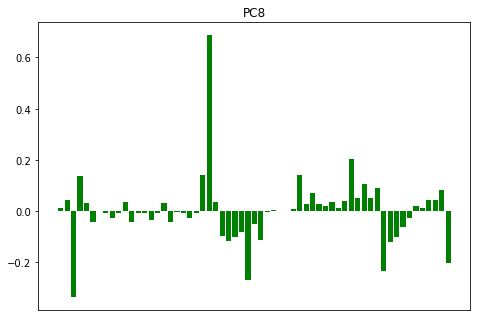



 Top features for PC8: 
     Feature  Component
0  e.S280MAG   0.685899
1   e.W856FD   0.204491
2   e.W646FD   0.141732
3    S280MAG   0.139676
4      mumax   0.138312
5   e.W914FD   0.107428
6   e.W914FE  0.0899463
7      e.IFD  0.0806566
8   e.W696FE  0.0716574
9     W914FD  0.0509516

Bottom features for PC8: 
        Feature  Component
51     e.W420FE -0.0968841
52     e.W462FE  -0.102828
53          BFS  -0.103204
54     e.W518FE  -0.114053
55       W462FE  -0.117973
56        e.UFS  -0.120185
57  galaxy_size  -0.203952
58          UFS  -0.235917
59     e.W485FD  -0.268118
60      ApDRmag  -0.336429


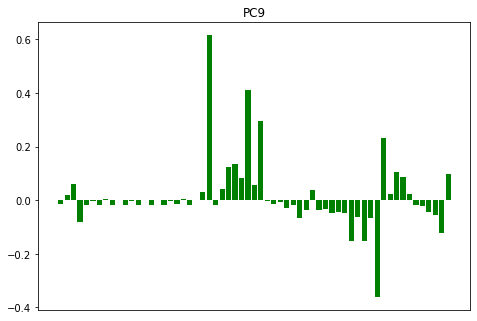



 Top features for PC9: 
       Feature  Component
0    e.S280MAG   0.614874
1     e.W485FD   0.409635
2     e.W518FE    0.29461
3          UFS   0.231744
4     e.W462FE    0.13666
5       W462FE   0.124711
6          BFS   0.106292
7  galaxy_size  0.0968403
8        e.BFS  0.0852311
9       W485FD  0.0812055

Bottom features for PC9: 
     Feature  Component
51    W856FD -0.0490929
52       IFD  -0.053803
53    W914FD -0.0643208
54  e.W646FD -0.0650208
55    W914FE -0.0654187
56     mumax -0.0802157
57     e.IFD  -0.124159
58  e.W914FD  -0.151269
59  e.W856FD  -0.152395
60  e.W914FE  -0.362071


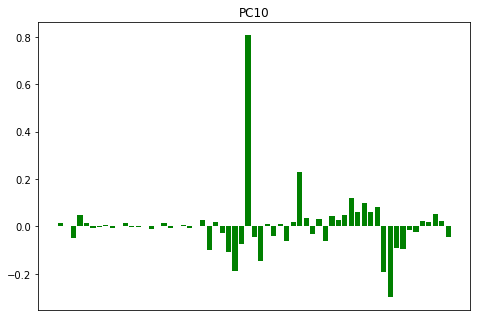



 Top features for PC10: 
    Feature  Component
0  e.W485FD   0.805107
1  e.W646FD   0.229667
2  e.W856FD   0.119516
3  e.W914FD   0.100673
4  e.W914FE  0.0812965
5    W914FD  0.0610928
6    W914FE  0.0606127
7       IFD  0.0510646
8     mumax  0.0476992
9    W856FD  0.0466337

Bottom features for PC10: 
      Feature  Component
51   e.W604FE -0.0631301
52     W485FD -0.0721159
53        BFS -0.0901327
54      e.BFS -0.0933569
55  e.S280MAG -0.0989541
56     W462FE  -0.109241
57   e.W518FE  -0.144917
58   e.W462FE  -0.186374
59        UFS  -0.193249
60      e.UFS  -0.298204


In [ ]:
# barplots and iterpretations
n_columns = combo_hat.shape[1]
comp_features = []
lists1 = []
lists2 = []

for p in range(10):
  comp_features = []
  for i in range(n_columns):
    comp_features.append(pca.components_[p,i])

  ind = np.argsort(comp_features)
  comp_features.sort(reverse = True)

  columns_sorted_bottom =[combo_pca_clean.columns[i] for i in ind]
  columns_sorted_top = columns_sorted_bottom.copy()
  columns_sorted_top.reverse()

  lists1.append(columns_sorted_top)
  lists2.append(comp_features)
  comp_order = pd.DataFrame([columns_sorted_top,comp_features]).transpose()
  comp_order.columns = ['Feature', 'Component']

  
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])
  ax.bar(range(pca.components_.shape[1]), pca.components_[p, :], color = 'green')
  ax.axes.get_xaxis().set_ticks([])
  ax.set_title('PC' + str(p+1))
  plt.show()
  print('\n\n Top features for PC' + str(p+1) + ': ')
  print(comp_order.head(10))
  print('\nBottom features for PC' + str(p+1) + ': ')
  print(comp_order.tail(10))

### PCA plots

In [ ]:
# PCA with 13 principal components
n = 13
pca13 = PCA(n_components = n, svd_solver = 'full')
pca13.fit(combo_hat)

# transform the data
combo_transformed = pca13.transform(combo_hat)

In [ ]:
# scatterplots

x = range(1,len(combo_pca_clean)+1)
target = combo_pca['Mcz']

#1D
fig = px.scatter(combo_transformed, x=x, y=0, color=target,
                 labels={'x': 'Galaxy observations', '0': 'Photon flux density'})
fig.show()


fig = px.scatter(combo_transformed, x=x, y=1, color=target,
                 labels={'x': 'Galaxy observations', '1': 'Magnitude'})
fig.show()


fig = px.scatter(combo_transformed, x=x, y=2, color=target, 
                 labels={'x': 'Galaxy observations', '2': 'Magnitude uncertainty'})
fig.show()



#2D
fig = px.scatter(combo_transformed, x=0, y=1, color=target,
                 labels={'0': 'Photon flux density', '1': 'Magnitude'})
fig.show()


fig = px.scatter(combo_transformed, x=0, y=2, color=target,
                 labels={'0': 'Photon flux density', '2': 'Magnitude uncertainty'})
fig.show()


fig = px.scatter(combo_transformed, x=1, y=2, color=target,
                 labels={'1': 'Magnitude', '2': 'Magnitude uncertainty'})
fig.show()

#3D
fig = px.scatter_3d(
    combo_transformed, x=0, y=1, z=2, color=target,
    labels={'0': 'Photon flux density', '1': 'Magnitude', '2': 'Magnitude uncertainty'})
fig.show()

# loading graph
features = combo_pca_clean.columns
loadings = pca.components_.T * 40* np.sqrt(pca.explained_variance_)
fig = px.scatter(combo_transformed, x=0, y=1, color=target, labels={"0": "Photon flux density",
                                                                    "1": "Magnitude"})
for i, feature in enumerate(features):
    # fig.add_shape(
    #     type='line',
    #     x0=0, y0=0,
    #     x1=loadings[i, 0],
    #     y1=loadings[i, 1]
    # )
    fig.add_annotation(
        x=loadings[i, 0],
        y=loadings[i, 1],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
    )

fig.show()

# Evaluation set analysis and k-NN

## PCA plots for evaluation set

In [ ]:
# pull-off from eval the features related to the redshift
combo_eval_clean = combo_eval.drop(['Nr','Mcz', 'e.Mcz', 'MCzml', 'chi2red'], axis = 1)
header_eval = list(combo_eval_clean.columns)
target_eval = combo_eval['Mcz']

# scaling data w.r.t. scaler of development set
z_norm = StandardScaler()
combo_hat = z_norm.fit_transform(combo_pca_clean)
combo_eval_hat = z_norm.transform(combo_eval_clean)

# PCA with 13 principal components
pca13 = PCA(n_components = 13, svd_solver = 'full')
combo_transformed = pca13.fit_transform(combo_hat)
combo_eval_transformed = pca13.transform(combo_eval_hat)

In [ ]:
# scatterplots on eval
x_eval = np.arange(len(target_eval))

#1D
fig = px.scatter(combo_eval_transformed, x=x_eval, y=0, color=target_eval, title='1D representation',
                 labels={'x': 'index', '0': 'PC 1'})
fig.show()

fig = px.scatter(combo_eval_transformed, x=x_eval, y=1, color=target_eval,
                 labels={'x': 'index', '1': 'PC 2'})
fig.show()

fig = px.scatter(combo_eval_transformed, x=x_eval, y=2, color=target_eval, 
                 labels={'x': 'index', '2': 'PC 3'})
fig.show()


#2D
fig = px.scatter(combo_eval_transformed, x=0, y=1, color=target_eval, title='2D representation',
                 labels={'0': 'PC 1', '1': 'PC 2'})
fig.show()

fig = px.scatter(combo_eval_transformed, x=0, y=2, color=target_eval,
                 labels={'0': 'PC 1', '2': 'PC 3'})
fig.show()

fig = px.scatter(combo_eval_transformed, x=1, y=2, color=target_eval,
                 labels={'1': 'PC 2', '2': 'PC 3'})
fig.show()

#3D
fig = px.scatter_3d(
    combo_eval_transformed, x=0, y=1, z=2, color=target_eval,
    title='3D representation',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'})
fig.show()

# loading graph
features_eval = combo_eval_clean.columns
loadings_eval = pca13.components_.T * 20 * np.sqrt(pca13.explained_variance_)
fig = px.scatter(combo_eval_transformed, x=0, y=1, color=target_eval)

for i, feature in enumerate(features_eval):
    #fig.add_shape(
        #type='line',
        #x0=0, y0=0,
        #x1=loadings_eval[i, 0],
        #y1=loadings_eval[i, 1]
    #)
    fig.add_annotation(
        x=loadings_eval[i, 0],
        y=loadings_eval[i, 1],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
    )
fig.show()

## k-NN 

In [ ]:
# grid search
parameters = [{'weights' : ['uniform', 'distance'], 'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15]}]
grid = GridSearchCV(KNeighborsRegressor(), parameters, scoring = 'neg_mean_absolute_error')
grid.fit(combo_transformed, target)
print(grid.best_params_)

# kNN with 13 PCs
knn = KNeighborsRegressor(weights = grid.best_params_['weights'], n_neighbors = grid.best_params_['n_neighbors'])
knn.fit(combo_transformed, target)
pred = knn.predict(combo_eval_transformed) 
print('MAE: ' + str(mean_absolute_error(target_eval, pred)))
print('MRE:' + str(mean_relative_error(target_eval, pred)))
print('MSE: ' + str(mean_squared_error(target_eval, pred)))
print('r2: ' + str(r2_score(target_eval, pred)))

{'n_neighbors': 7, 'weights': 'distance'}
MAE: 0.056167322246419196
MRE:0.09960094490262661
MSE: 0.006300660145338678
r2: 0.9372861813269902


In [ ]:
# kNN with PCs between 2 and 15
MSE = []
MAE = []
MRE = []
R2 = []
for i in range(2,16):

  # PCA
  pca_i = PCA(n_components = i, svd_solver = 'full')
  combo_transformed = pca_i.fit_transform(combo_hat)
  combo_eval_transformed = pca_i.transform(combo_eval_hat)

  # grid search
  parameters = [{'weights' : ['uniform', 'distance'], 'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15]}]
  grid = GridSearchCV(KNeighborsRegressor(), parameters, scoring = 'neg_mean_absolute_error')
  grid.fit(combo_transformed, target)
  print('\n\n Best parameter for number of components = ' + str(i) + ':\n')
  print(grid.best_params_)

  # kNN
  knn = KNeighborsRegressor(weights = grid.best_params_['weights'], n_neighbors = grid.best_params_['n_neighbors'])
  knn.fit(combo_transformed, target)
  pred = knn.predict(combo_eval_transformed)

  # errors and R2 score
  MAE.append(mean_absolute_error(target_eval, pred))
  MRE.append(mean_relative_error(target_eval, pred))
  MSE.append(mean_squared_error(target_eval, pred))
  R2.append(r2_score(target_eval, pred))
  print('\n\n Number of components = ' + str(i) + '\n')
  print('MAE: ' + str(mean_absolute_error(target_eval, pred)))
  print('MRE:' + str(mean_relative_error(target_eval, pred)))
  print('MSE: ' + str(mean_squared_error(target_eval, pred)))
  print('r2: ' + str(r2_score(target_eval, pred)))



 Best parameter for number of components = 2

{'n_neighbors': 15, 'weights': 'uniform'}


 Number of components = 2

MAE: 0.14034256
MRE:0.28647593
MSE: 0.03399916
r2: 0.661588259652758


 Best parameter for number of components = 3

{'n_neighbors': 7, 'weights': 'distance'}


 Number of components = 3

MAE: 0.055644401651841875
MRE:0.094271246879332
MSE: 0.0061627779497628885
r2: 0.9386585960918102


 Best parameter for number of components = 4

{'n_neighbors': 7, 'weights': 'distance'}


 Number of components = 4

MAE: 0.04266089765826917
MRE:0.06390510948214916
MSE: 0.0038148498670857703
r2: 0.9620287720158706


 Best parameter for number of components = 5

{'n_neighbors': 7, 'weights': 'distance'}


 Number of components = 5

MAE: 0.04042519575416221
MRE:0.0618726069856008
MSE: 0.00348819644433872
r2: 0.965280127120023


 Best parameter for number of components = 6

{'n_neighbors': 7, 'weights': 'distance'}


 Number of components = 6

MAE: 0.04380099586809531
MRE:0.0683976100573

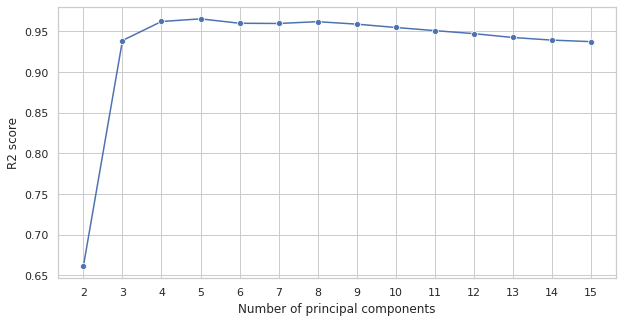

In [ ]:
# plots

# R2 score
sns.set(style="whitegrid", rc={'figure.figsize':(10,5)})
sns.lineplot(x=range(2,16), y=R2, marker='o')
plt.xticks(range(2,16))
plt.xlabel('Number of principal components')
plt.ylabel('R2 score')
# plt.savefig("r2.eps", bbox_inches='tight')

# MAE
sns.set(style="whitegrid", rc={'figure.figsize':(6,5)})
sns.lineplot(x=range(2,16), y=MAE, marker='o')
plt.xticks(range(2,16))
plt.xlabel('Number of principal components')
plt.ylabel('Mean Absolute Error')
#plt.savefig("MAE.eps", bbox_inches='tight')

#MRE
sns.set(style="whitegrid", rc={'figure.figsize':(6,5)})
sns.lineplot(x=range(2,16), y=MRE, marker='o')
plt.xticks(range(2,16))
plt.xlabel('Number of principal components')
plt.ylabel('Mean Relative Error')
#plt.savefig("MRE.eps", bbox_inches='tight')